In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold


import warnings; warnings.filterwarnings('ignore')


In [288]:
data_raw = pd.read_csv('C:/Users/Peter/Documents/GitHub/project/cfp_dataset_v1.csv')

data_valid_raw = pd.read_csv('C:/Users/Peter/Documents/GitHub/project/cfp_dataset_v1_valid1.csv')

data_raw.drop(['Unnamed: 0','MIDUPT1138P2300058',
               'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'T1013P500399'], axis=1, inplace=True)
data_valid_raw.drop(['Unnamed: 0','MIDUPT1138P2300058',
               'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'T1013P500399'], axis=1, inplace=True)

data_raw.rename(columns={
    'T1138P6000096': "engine", 
 'T1138P6000315': "«engine_idle",
 'DMIDT1138P4000064': "workload_сh_d",
 'DSHORTT1138P4000064': "workload_сh_h",
 'DLONGT1138P4000064': "workload_сh_w",
 'DMIDT1138P2600012': "curr_сh_d",
 'DSHORTT1138P2600012': "curr_сh_h",
 'DLONGT1138P2600012': "curr_сh_w",
'DMIDT1205P2300000': "press_сh_d»",
 'DSHORTT1205P2300000': "press_сh_h»",
 'DLONGT1205P2300000': "press_сh_w",
'T1205P2300000': "press_coll",
 'T1138P4000064': "workload_eng",
 'T1138P2600012': "curr",
 'T1138P600050': "power_coef",
 'T1013P500399': "liq",
 'DMIDT1138P2300058': "targ_press_d",
 'DSHORTT1138P2300058': "targ_press_h",
 'DLONGT1138P2300058': "targ_press_w"
                  }, inplace=True)

data_raw.drop(['UUID','UNIXDT'], axis=1, inplace=True)

data_raw['DT'] = pd.to_datetime(data_raw['DT'])
data_valid_raw['DT'] = pd.to_datetime(data_valid_raw['DT'])


data_valid_raw.rename(columns={
    'T1138P6000096': "engine", 
 'T1138P6000315': "«engine_idle",
 'DMIDT1138P4000064': "workload_сh_d",
 'DSHORTT1138P4000064': "workload_сh_h",
 'DLONGT1138P4000064': "workload_сh_w",
 'DMIDT1138P2600012': "curr_сh_d",
 'DSHORTT1138P2600012': "curr_сh_h",
 'DLONGT1138P2600012': "curr_сh_w",
'DMIDT1205P2300000': "press_сh_d»",
 'DSHORTT1205P2300000': "press_сh_h»",
 'DLONGT1205P2300000': "press_сh_w",
'T1205P2300000': "press_coll",
 'T1138P4000064': "workload_eng",
 'T1138P2600012': "curr",
 'T1138P600050': "power_coef",
 'T1013P500399': "liq",
 'DMIDT1138P2300058': "targ_press_d",
 'DSHORTT1138P2300058': "targ_press_h",
 'DLONGT1138P2300058': "targ_press_w"
                  }, inplace=True)

data_valid_raw.drop(['UUID','UNIXDT'], axis=1, inplace=True)



#проверим пропуски
{key:data_raw[key].isna().sum() for key in data_raw.columns}




{'WELL_ID': 0,
 'DT': 0,
 'engine': 0,
 '«engine_idle': 0,
 'workload_сh_d': 0,
 'workload_сh_h': 0,
 'workload_сh_w': 0,
 'curr_сh_d': 0,
 'curr_сh_h': 0,
 'curr_сh_w': 0,
 'press_сh_d»': 0,
 'press_сh_h»': 0,
 'press_сh_w': 0,
 'press_coll': 1,
 'workload_eng': 0,
 'curr': 0,
 'power_coef': 0,
 'targ_press_d': 0,
 'targ_press_h': 0,
 'targ_press_w': 0}

'T1138P6000096': "Наработка двигателя с момента последнего включения, сек"  **engine**  
'T1138P6000315': "«Время простоя двигателя с момента последнего выключения, сек", **engine_idle**    
'DMIDT1138P4000064': "Средняя скорость изменения загрузки двигателя СУТ, %/час",  **workload_сh_d**  
'DSHORTT1138P4000064': "Средняя скорость изменения загрузки двигателя ЧАС, %/час",  **workload_сh_h**  
'DLONGT1138P4000064': "Средняя скорость изменения загрузки двигателя НЕДЕЛЯ, %/час",  **workload_сh_w**  
'DMIDT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в СУТ, А/час",  **curr_сh_d**  
'DSHORTT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в ЧАС, А/час",  **curr_сh_h**  
'DLONGT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в НЕДЕЛЯ, А/час", **curr_сh_w**   
'DMIDT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в СУТ, МПа/час»", **press_сh_d**   
'DSHORTT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в ЧАС, МПа/час»",  **press_сh_h**  
'DLONGT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в НЕДЕЛЯ, МПа/час»",  **press_сh_w**  
'T1205P2300000': "Давление в коллекторе измерительной установки, МПа",  **press_coll**  
'T1138P4000064': "Загрузка двигателя, %",  **workload_eng**  
'T1138P2600012': "Ток фазы A двигателя, А",  **curr**  
'T1138P600050': "Коэффициент мощности (cos fi)",  **power_coef**  
'T1013P500399': "Объём жидкости в рабочих условиях за время наработки суточный, м3",  **liq**  
'DMIDT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса в СУТ, МПа/час", **targ_press_d**   
'DSHORTT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса в ЧАС, МПа/час",  **targ_press_h**  
'DLONGT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса НЕДЕЛЯ, МПа/час"  **targ_press_w**  

<AxesSubplot:>

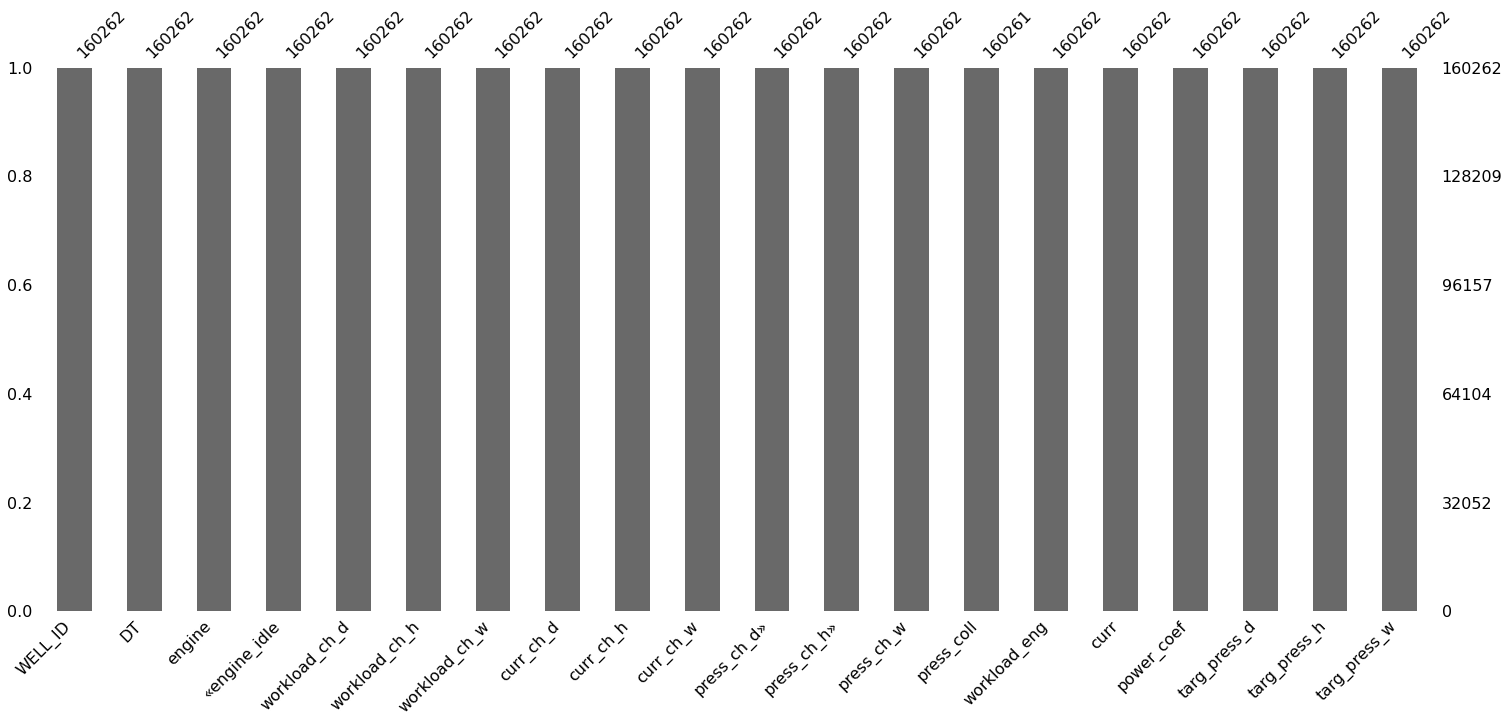

In [4]:
#выводим данные на график, чтобы визуально просмотреть наличие пропусков и сколько пропусков в данных
msno.bar(data_raw)

In [5]:
# увидели что пропущено только одно значение, заполним его средним
median_press = data_raw['press_coll'].median()
data_raw['press_coll'].fillna(median_press, inplace=True)

In [6]:
# дальше работаем с входными данными, преобразовывая их для удобства дальнейшей обработки

data_prep = data_raw.copy()
data_valid_prep = data_valid_raw.copy()

data_prep['hour'] = data_prep['DT'].dt.hour
data_prep['day_w'] = data_prep['DT'].dt.dayofweek

data_valid_prep['hour'] = data_valid_prep['DT'].dt.hour
data_valid_prep['day_w'] = data_valid_prep['DT'].dt.dayofweek

data_prep.set_index(['WELL_ID','DT'],inplace=True)
data_valid_prep.set_index(['WELL_ID','DT'],inplace=True)

data_prep = data_prep.sort_index()
data_valid_prep = data_valid_prep.sort_index()

In [7]:
X_train = data_prep.drop(['targ_press_d','targ_press_h','targ_press_w'],axis=1)
y_train = data_prep['targ_press_h']

In [8]:
y_train

WELL_ID    DT                 
226000188  2019-06-27 06:40:00    0.0000
           2019-06-27 06:45:00    0.0000
           2019-06-27 06:50:00    0.0000
           2019-06-27 06:55:00    0.0000
           2019-06-27 07:00:00    0.0000
                                   ...  
226003330  2019-07-31 23:35:00    0.0000
           2019-07-31 23:40:00    0.0000
           2019-07-31 23:45:00    0.0000
           2019-07-31 23:50:00    0.0000
           2019-07-31 23:55:00   -0.1344
Name: targ_press_h, Length: 160262, dtype: float64

In [9]:
X_train

engine  «engine_idle  workload_сh_d  \
WELL_ID   DT                                                         
226000188 2019-06-27 06:40:00       0         13200      -3.232999   
          2019-06-27 06:45:00       0         13500      -3.232999   
          2019-06-27 06:50:00       0         13800      -3.232999   
          2019-06-27 06:55:00       0         14100      -3.232999   
          2019-06-27 07:00:00       0         14400      -3.232999   
...                               ...           ...            ...   
226003330 2019-07-31 23:35:00       0         27900      -2.172480   
          2019-07-31 23:40:00       0         28200      -2.172480   
          2019-07-31 23:45:00       0         28500      -2.172480   
          2019-07-31 23:50:00       0             0      -2.172480   
          2019-07-31 23:55:00     300             0      -2.150755   

                               workload_сh_h  workload_сh_w  curr_сh_d  \
WELL_ID   DT                                                             
226000188 2019-06-27 06:40:00            0.0      -4.138484  -0.423734   
          2019-06-27 06:45:00            0.0      -4.138484  -0.423734   
          2019-06-27 06:50:00            0.0      -4.138484  -0.423734   
          2019-06-27 06:55:00            0.0      -4.138484  -0.423734   
          2019-06-27 07:00:00            0.0      -4.138484  -0.423734   
...                                      ...            ...        ...   
226003330 2019-07-31 23:35:00            0.0      -2.292904  -0.281889   
          2019-07-31 23:40:00            0.0      -2.292904  -0.281889   
          2019-07-31 23:45:00            0.0      -2.292904  -0.281889   
          2019-07-31 23:50:00            0.0      -2.292904  -0.281889   
          2019-07-31 23:55:00            0.0      -2.290611  -0.279070   

                               curr_сh_h  curr_сh_w  press_сh_d»  press_сh_h»  \
WELL_ID   DT                                                                    
226000188 2019-06-27 06:40:00        0.0  -0.656976     0.001927     0.000000   
          2019-06-27 06:45:00        0.0  -0.656976     0.001927     0.000000   
          2019-06-27 06:50:00        0.0  -0.656976     0.001927     0.000000   
          2019-06-27 06:55:00        0.0  -0.656976     0.001927     0.000000   
          2019-06-27 07:00:00        0.0  -0.656976     0.001927     0.000000   
...                                  ...        ...          ...          ...   
226003330 2019-07-31 23:35:00        0.0  -0.314066    -0.001172     0.000000   
          2019-07-31 23:40:00        0.0  -0.314066    -0.001172     0.000000   
          2019-07-31 23:45:00        0.0  -0.314066    -0.001172     0.000000   
          2019-07-31 23:50:00        0.0  -0.314066    -0.001172     0.000000   
          2019-07-31 23:55:00        0.0  -0.313752    -0.001102     0.000587   

                               press_сh_w  press_coll  workload_eng  curr  \
WELL_ID   DT                                                                
226000188 2019-06-27 06:40:00    0.000129    1.648583             0   0.0   
          2019-06-27 06:45:00    0.000129    1.681818             0   0.0   
          2019-06-27 06:50:00    0.000129    1.650049             0   0.0   
          2019-06-27 06:55:00    0.000129    1.648583             0   0.0   
          2019-06-27 07:00:00    0.000129    1.642718             0   0.0   
...                                   ...         ...           ...   ...   
226003330 2019-07-31 23:35:00   -0.000251    1.162268             0   0.0   
          2019-07-31 23:40:00   -0.000251    1.160802             0   0.0   
          2019-07-31 23:45:00   -0.000251    1.161290             0   0.0   
          2019-07-31 23:50:00   -0.000251    1.167644            70  19.6   
          2019-07-31 23:55:00   -0.000245    1.168133            70  19.6   

                               power_coef  hour  day_w  
WELL_ID   DT                                

In [35]:
X_train[X_train.index == 226000188]

,,engine,«engine_idle,workload_сh_d,workload_сh_h,workload_сh_w,curr_сh_d,curr_сh_h,curr_сh_w,press_сh_d»,press_сh_h»,press_сh_w,press_coll,workload_eng,curr,power_coef,hour,day_w
WELL_ID,DT,,,,,,,,,,,,,,,,,


In [93]:
data_one_id = X_train.reset_index()
pumps = set(data_one_id['WELL_ID'])

In [94]:
data_one_id = data_one_id[data_one_id['WELL_ID'] == 226000188]
data_one_id = data_one_id.set_index('DT')
data_one_id.drop(['WELL_ID'], axis=1, inplace=True)
# data_one_id = (data_one_id - data_one_id.mean())/data_one_id.std()
data_one_id

,engine,«engine_idle,workload_сh_d,workload_сh_h,workload_сh_w,curr_сh_d,curr_сh_h,curr_сh_w,press_сh_d»,press_сh_h»,press_сh_w,press_coll,workload_eng,curr,power_coef,hour,day_w
DT,,,,,,,,,,,,,,,,,
2019-06-27 06:40:00,-0.570840,0.380081,0.374159,0.297338,0.258276,0.079470,0.278468,-2.075705,-0.237134,-0.040648,-1.597112,2.670077,-0.694522,-0.705579,-0.701991,-0.809015,0.000599
2019-06-27 06:45:00,-0.570840,0.411408,0.374159,0.297338,0.258276,0.079470,0.278468,-2.075705,-0.237134,-0.040648,-1.597112,3.282399,-0.694522,-0.705579,-0.701991,-0.809015,0.000599
2019-06-27 06:50:00,-0.570840,0.442734,0.374159,0.297338,0.258276,0.079470,0.278468,-2.075705,-0.237134,-0.040648,-1.597112,2.697086,-0.694522,-0.705579,-0.701991,-0.809015,0.000599
2019-06-27 06:55:00,-0.570840,0.474061,0.374159,0.297338,0.258276,0.079470,0.278468,-2.075705,-0.237134,-0.040648,-1.597112,2.670077,-0.694522,-0.705579,-0.701991,-0.809015,0.000599
2019-06-27 07:00:00,-0.570840,0.505387,0.374159,0.297338,0.258276,0.079470,0.278468,-2.075705,-0.237134,-0.040648,-1.597112,2.562020,-0.694522,-0.705579,-0.701991,-0.664144,0.000599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 23:35:00,0.164351,-0.998281,-2.879696,-3.933784,-2.897643,-1.638318,-3.645233,1.249996,2.215209,0.204589,3.214485,0.193725,1.186637,1.363773,1.269317,1.653802,-0.497346
2019-07-31 23:40:00,0.237870,-0.998281,-2.802885,-3.510672,-2.842129,-1.692029,-3.428649,1.233595,2.228642,0.258698,3.226163,0.229744,1.186637,1.352465,1.269317,1.653802,-0.497346
2019-07-31 23:45:00,0.311389,-0.998281,-2.891169,-3.370733,-2.938489,-1.635617,-3.057937,1.246106,2.200586,0.228763,3.221249,0.229744,1.145742,1.352465,1.223059,1.653802,-0.497346


In [152]:
y_train_one_id = y_train.reset_index()
y_train_one_id = y_train_one_id[y_train_one_id['WELL_ID']==226000188]
y_train_one_id = y_train_one_id.set_index('DT')
y_train_one_id.drop(['WELL_ID'], axis=1, inplace=True)
y_train_one_id

,targ_press_h
DT,
2019-06-27 06:40:00,0.000000
2019-06-27 06:45:00,0.000000
2019-06-27 06:50:00,0.000000
2019-06-27 06:55:00,0.000000
2019-06-27 07:00:00,0.000000
...,...
2019-07-31 23:35:00,-0.826162
2019-07-31 23:40:00,-0.765146
2019-07-31 23:45:00,-0.713831


In [154]:
y_train_one_id_2sigma = [y_train_one_id.mean() - 2 * y_train_one_id.std(), y_train_one_id.mean() + 2 * y_train_one_id.std()]
y_train_one_id_3sigma = [y_train_one_id.mean() - 3 * y_train_one_id.std(), y_train_one_id.mean() + 3 * y_train_one_id.std()]
y_train_one_id_2sigma

[targ_press_h   -0.655871
 dtype: float64,
 targ_press_h    0.339848
 dtype: float64]

In [155]:
two_sigma = pd.Interval(left=float(y_train_one_id.mean() - 2 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 2 * y_train_one_id.std()),closed='both')
three_sigma = pd.Interval(left=float(y_train_one_id.mean() - 3 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 3 * y_train_one_id.std()),closed='both')
two_sigma, three_sigma

(Interval(-0.6558707580417951, 0.339847545423764, closed='both'),
 Interval(-0.9048003339081847, 0.5887771212901538, closed='both'))

In [162]:
y_train_one_id['2sigma'] = [ 0 if x in two_sigma else 1 for x in y_train_one_id['targ_press_h']]
y_train_one_id['3sigma'] = [ 0 if x in three_sigma else 1 for x in y_train_one_id['targ_press_h']]

print(len(y_train_one_id[y_train_one_id['2sigma'] == 1]))
print(len(y_train_one_id[y_train_one_id['3sigma'] == 1]))

571
45


In [202]:
y_draw = y_train_one_id.reset_index()['DT']
y_draw

0      2019-06-27 06:40:00
1      2019-06-27 06:45:00
2      2019-06-27 06:50:00
3      2019-06-27 06:55:00
4      2019-06-27 07:00:00
               ...        
9970   2019-07-31 23:35:00
9971   2019-07-31 23:40:00
9972   2019-07-31 23:45:00
9973   2019-07-31 23:50:00
9974   2019-07-31 23:55:00
Name: DT, Length: 9975, dtype: datetime64[ns]

In [230]:
y_draw = y_train_one_id[:]
y_draw

,targ_press_h,2sigma,3sigma
DT,,,
2019-06-27 06:40:00,0.000000,0,0
2019-06-27 06:45:00,0.000000,0,0
2019-06-27 06:50:00,0.000000,0,0
2019-06-27 06:55:00,0.000000,0,0
2019-06-27 07:00:00,0.000000,0,0
...,...,...,...
2019-07-31 23:35:00,-0.826162,1,0
2019-07-31 23:40:00,-0.765146,1,0
2019-07-31 23:45:00,-0.713831,1,0


In [171]:
plt.plot??

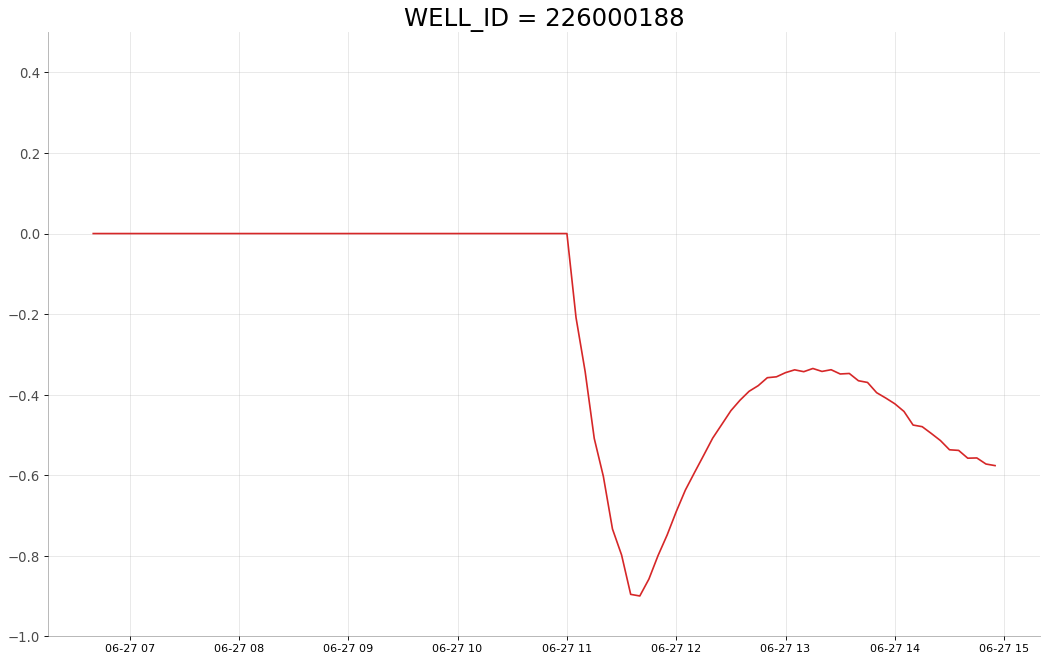

In [225]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot('DT', 'targ_press_h', data=y_draw, color='tab:red')

# Decoration
plt.ylim(-1, 0.5)
# xtick_location = y_draw.index
# xtick_labels = [x[-4:] for x in y_train_one_id.date.tolist()[::12]]
# xtick_labels = y_draw.index
# plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("WELL_ID = 226000188", fontsize=22)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

<AxesSubplot:xlabel='DT'>

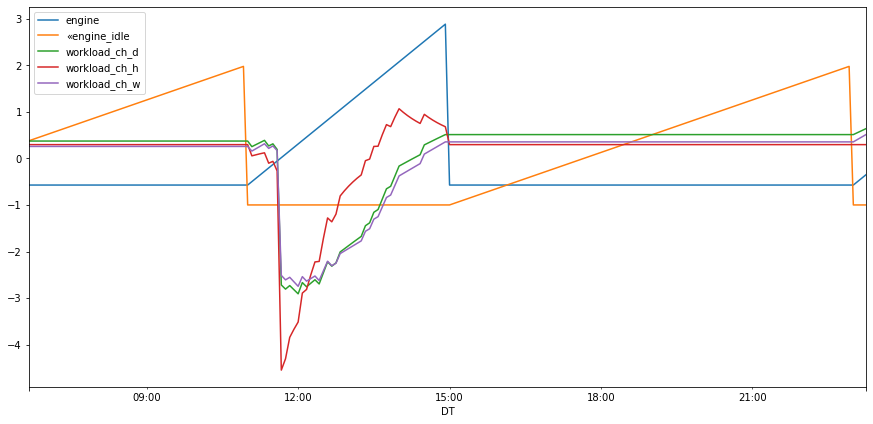

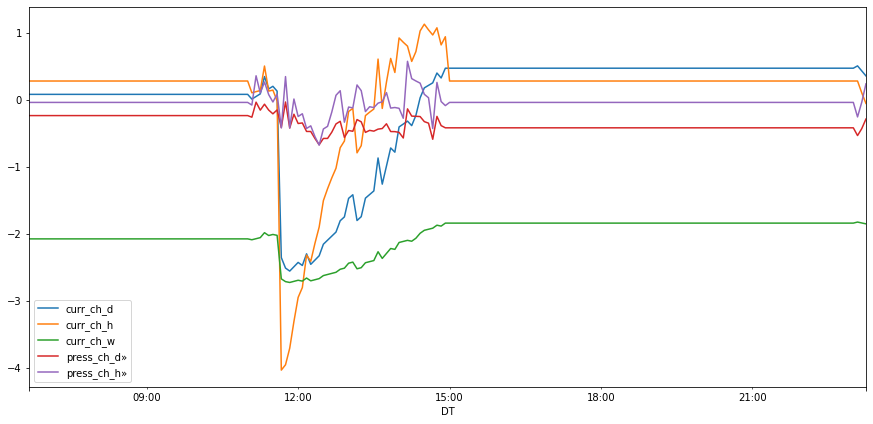

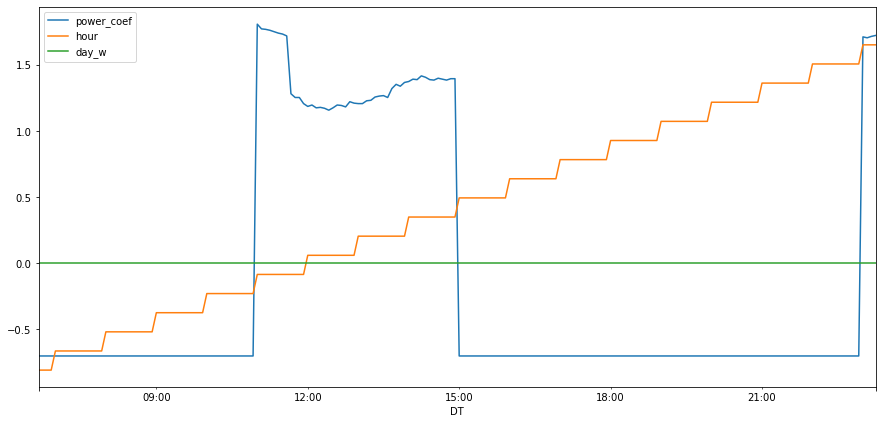

In [73]:
plt.rcParams["figure.figsize"] = (15,7)
data_one_id.iloc[:200,:5].plot()
data_one_id.iloc[:200,5:10].plot()
data_one_id.iloc[:200,-3:].plot()

<AxesSubplot:xlabel='DT'>

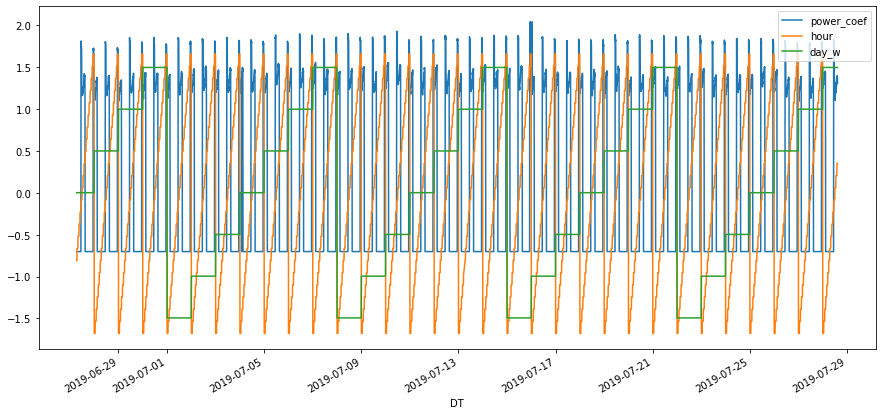

In [232]:
data_one_id.iloc[:9000,-3:].plot()

In [240]:
X_train_one_id, X_test_one_id, y_train_one_id, y_test_one_id = train_test_split(data_one_id, y_train_one_id, test_size = 0.33)

In [253]:
from sklearn.metrics import (roc_auc_score, recall_score, f1_score, precision_score,
                            accuracy_score)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    

In [242]:
#Random Forest

#кросс-валидация, подбор гипер-параметров
# skf = StratifiedKFold(n_splits=5)  # CV type по умолчанию для binary или multiclass
skf = KFold(n_splits=5)

pipe_rndforest = Pipeline([
#     ('scl', preprocessor),
                           ('reg', RandomForestRegressor( random_state=13))
                        ])  # pipeline with all steps
param_dict_rndforest = {
#     'reg__max_depth': np.arange(1,10),
#                         'reg__min_samples_leaf': np.arange(1, 10),
                        'reg__n_estimators': [100, 200, 300]
                       }

rndforest_randomized_pipe_2sigma = RandomizedSearchCV(estimator=pipe_rndforest,
                                              param_distributions=param_dict_rndforest,
                                               error_score="neg_mean_squared_error",
                                              cv=skf, n_iter=30, n_jobs=-1)

In [234]:
y_train_one_id['2sigma']

DT
2019-06-27 06:40:00    0
2019-06-27 06:45:00    0
2019-06-27 06:50:00    0
2019-06-27 06:55:00    0
2019-06-27 07:00:00    0
                      ..
2019-07-31 23:35:00    1
2019-07-31 23:40:00    1
2019-07-31 23:45:00    1
2019-07-31 23:50:00    1
2019-07-31 23:55:00    0
Name: 2sigma, Length: 9975, dtype: int64

In [236]:
rndforest_randomized_pipe

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='neg_mean_squared_error',
                   estimator=Pipeline(steps=[('reg',
                                              RandomForestRegressor(random_state=13))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'reg__n_estimators': [100, 200, 300]})

In [243]:
rndforest_randomized_pipe_2sigma.fit(X_train_one_id, y_train_one_id['2sigma'])

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='neg_mean_squared_error',
                   estimator=Pipeline(steps=[('reg',
                                              RandomForestRegressor(random_state=13))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'reg__n_estimators': [100, 200, 300]})

In [260]:
y_test_one_id_2sigma = y_test_one_id['2sigma']

In [261]:
y_test_one_id_2sigma

DT
2019-06-28 05:45:00    0
2019-07-11 04:40:00    0
2019-07-09 01:00:00    0
2019-07-01 20:05:00    0
2019-07-16 12:10:00    0
                      ..
2019-06-28 12:40:00    0
2019-07-18 18:15:00    0
2019-07-29 06:30:00    0
2019-07-24 08:40:00    0
2019-07-20 00:00:00    0
Name: 2sigma, Length: 3292, dtype: int64

In [267]:
model_predict = rndforest_randomized_pipe_2sigma.predict(X_test_one_id)
pred = np.round(model_predict, 0)
print('accuracy_score:', accuracy_score(y_test_one_id_2sigma, pred),
      'recall_score:',recall_score(y_test_one_id_2sigma, pred),
      'f1_score:',f1_score(y_test_one_id_2sigma, pred),
'precision_score:',precision_score(y_test_one_id_2sigma, pred),
    'roc_auc_score:',roc_auc_score(y_test_one_id_2sigma, pred))

accuracy_score: 0.9957472660996355 recall_score: 0.9411764705882353 f1_score: 0.9617486338797813 precision_score: 0.9832402234636871 roc_auc_score: 0.9701051435066781


,targ_press_h,2sigma,3sigma
DT,,,
2019-06-29 17:10:00,0.000000,0,0
2019-07-03 04:20:00,0.000000,0,0
2019-07-19 19:55:00,0.000000,0,0
2019-07-14 21:20:00,0.000000,0,0
2019-07-09 15:35:00,0.000000,0,0
...,...,...,...
2019-07-27 15:50:00,0.000000,0,0
2019-07-16 11:10:00,-0.481212,0,0
2019-06-27 12:25:00,-0.474101,0,0


In [20]:
roc_auc_score
, recall_score, f1_score, precision_score,
                            accuracy_score

IndentationError: unexpected indent (<ipython-input-20-f013832b05c9>, line 3)

In [21]:
y_train = pd.DataFrame(y_train)

In [268]:
y_train

targ_press_h
WELL_ID   DT                               
226000188 2019-06-27 06:40:00        0.0000
          2019-06-27 06:45:00        0.0000
          2019-06-27 06:50:00        0.0000
          2019-06-27 06:55:00        0.0000
          2019-06-27 07:00:00        0.0000
...                                     ...
226003330 2019-07-31 23:35:00        0.0000
          2019-07-31 23:40:00        0.0000
          2019-07-31 23:45:00        0.0000
          2019-07-31 23:50:00        0.0000
          2019-07-31 23:55:00       -0.1344

[160262 rows x 1 columns]

In [269]:
reset_y_train = y_train.reset_index()
print(reset_y_train)
reset_y_train['WELL_ID'].nunique()
y = reset_y_train[reset_y_train['WELL_ID'] == 226000188]

          WELL_ID                  DT  targ_press_h
0       226000188 2019-06-27 06:40:00        0.0000
1       226000188 2019-06-27 06:45:00        0.0000
2       226000188 2019-06-27 06:50:00        0.0000
3       226000188 2019-06-27 06:55:00        0.0000
4       226000188 2019-06-27 07:00:00        0.0000
...           ...                 ...           ...
160257  226003330 2019-07-31 23:35:00        0.0000
160258  226003330 2019-07-31 23:40:00        0.0000
160259  226003330 2019-07-31 23:45:00        0.0000
160260  226003330 2019-07-31 23:50:00        0.0000
160261  226003330 2019-07-31 23:55:00       -0.1344

[160262 rows x 3 columns]


In [270]:
y.drop(['WELL_ID'], axis=1, inplace=True)

In [271]:
y = y.set_index('DT')

<AxesSubplot:>

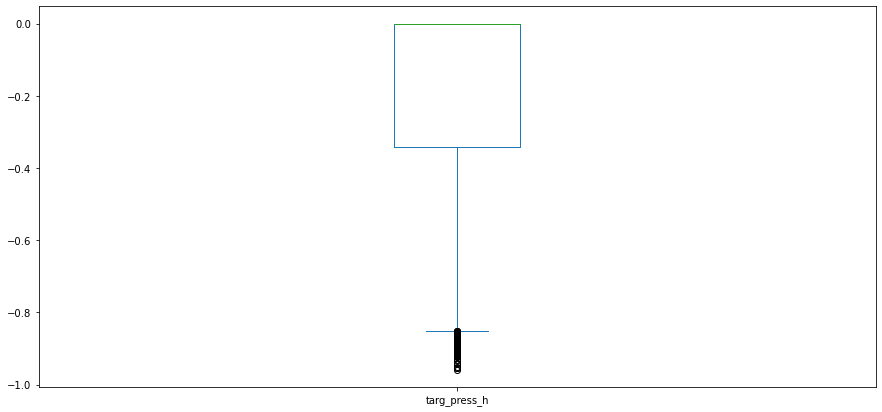

In [272]:
y.plot(kind='box')

In [273]:
y

,targ_press_h
DT,
2019-06-27 06:40:00,0.000000
2019-06-27 06:45:00,0.000000
2019-06-27 06:50:00,0.000000
2019-06-27 06:55:00,0.000000
2019-06-27 07:00:00,0.000000
...,...
2019-07-31 23:35:00,-0.826162
2019-07-31 23:40:00,-0.765146
2019-07-31 23:45:00,-0.713831


In [279]:
# init setup
from pycaret.anomaly import *
s = setup(y, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(9975, 1)"
2,Missing Values,False
3,Numeric Features,1
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(9975, 1)"
9,CPU Jobs,-1


In [126]:
s1 = setup(X_train, session_id = 124)

,Description,Value
0,session_id,124
1,Original Data,"(160262, 17)"
2,Missing Values,False
3,Numeric Features,16
4,Categorical Features,1
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(160262, 23)"
9,CPU Jobs,-1


In [281]:
# train model
iforestx = create_model('iforest', fraction = 0.01)
iforestx_results = assign_model(iforestx)
iforestx_results.head()
iforestx_results[iforestx_results['Anomaly'] == 1]

,targ_press_h,Anomaly,Anomaly_Score
DT,,,
2019-06-27 11:35:00,-0.896054,1,0.008737
2019-06-27 11:40:00,-0.900049,1,0.014935
2019-06-27 23:35:00,-0.895440,1,0.007789
2019-06-27 23:40:00,-0.918696,1,0.040206
2019-06-28 11:35:00,-0.897661,1,0.011115
...,...,...,...
2019-07-30 23:25:00,-0.932521,1,0.050695
2019-07-31 11:25:00,-0.932029,1,0.050695
2019-07-31 11:30:00,-0.896426,1,0.009212


In [276]:
iforestx.predict(X_)

NameError: name 'X_' is not defined

In [280]:
# train model
iforest = create_model('iforest', fraction = 0.01)
iforest_results = assign_model(iforest)
iforest_results.head()

,targ_press_h,Anomaly,Anomaly_Score
DT,,,
2019-06-27 06:40:00,0.0,0,-0.249894
2019-06-27 06:45:00,0.0,0,-0.249894
2019-06-27 06:50:00,0.0,0,-0.249894
2019-06-27 06:55:00,0.0,0,-0.249894
2019-06-27 07:00:00,0.0,0,-0.249894


In [107]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [108]:
# train model 2
lof_model = create_model('lof', fraction = 0.01)
lof_model_results = assign_model(lof_model)
lof_model_results.head()

,targ_press_h,Anomaly,Anomaly_Score
DT,,,
2019-06-27 06:40:00,0.0,0,1.0
2019-06-27 06:45:00,0.0,0,1.0
2019-06-27 06:50:00,0.0,0,1.0
2019-06-27 06:55:00,0.0,0,1.0
2019-06-27 07:00:00,0.0,0,1.0


In [110]:
len(lof_model_results[lof_model_results['Anomaly'] == 1])

100

In [103]:
len(iforest_results[iforest_results['Anomaly'] == 1])

96

In [125]:
result_compare = lof_model_results[lof_model_results['Anomaly'] == 1].join(iforest_results[iforest_results['Anomaly'] == 1],
                                                          lsuffix='_lof',rsuffix='_iforest',how='outer')
result_compare[result_compare.isna().sum(axis=1)==0]

,targ_press_h_lof,Anomaly_lof,Anomaly_Score_lof,targ_press_h_iforest,Anomaly_iforest,Anomaly_Score_iforest
DT,,,,,,
2019-06-27 11:40:00,-0.900049,1.0,1.286005,-0.900049,1.0,0.014935
2019-06-29 23:40:00,-0.901783,1.0,1.372732,-0.901783,1.0,0.018777
2019-07-06 23:35:00,-0.941540,1.0,2.009205,-0.941540,1.0,0.054731
2019-07-06 23:40:00,-0.919386,1.0,1.217402,-0.919386,1.0,0.040206
2019-07-07 11:35:00,-0.941605,1.0,2.011616,-0.941605,1.0,0.054731
2019-07-07 23:35:00,-0.953498,1.0,2.480302,-0.953498,1.0,0.055236
2019-07-08 11:35:00,-0.919162,1.0,1.205997,-0.919162,1.0,0.040206
2019-07-08 23:35:00,-0.940442,1.0,1.968303,-0.940442,1.0,0.054225
2019-07-08 23:40:00,-0.902798,1.0,1.366471,-0.902798,1.0,0.020633


In [56]:
# check anomalies
iforest_results[iforest_results['Anomaly'] == 1].head()

,targ_press_h,Anomaly,Anomaly_Score
DT,,,
2019-06-27 11:05:00,-0.208800,1,0.104262
2019-06-27 11:20:00,-0.603163,1,0.000212
2019-06-27 11:25:00,-0.733647,1,0.066413
2019-06-27 11:30:00,-0.798282,1,0.071157
2019-06-27 11:35:00,-0.896054,1,0.127350


In [278]:
import plotly.express as px
import plotly.graph_objects as go
# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index, y="targ_press_h", title='Pump anomally', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['targ_press_h'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

NameError: name 'iforest_results' is not defined

1. уточнить, нужно ли прогнозировать target как задачу регрессии, или нужно также искать аномалии(ответ - да), 
2. если нужно искать аномалии, то что под ними понимать:
    2.1 выбросы по y (по изменению давления, те что выходит за усики boxplot (выброс)
    2.2 поиск по pycaret как задача unsupervized learning (новизна)
3. как решать как unsupervized или supervied, если supervized, как формировать разметку?
4. уточнить - качество смотреть финальное на валидационной выборке, как валидировать?
5. использовать ли id насоса как dummy переменную(как в панельной регрессии в эконометрике)



